In [238]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm
from torch.nn.functional import interpolate
from skimage.metrics import structural_similarity as ssim


device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
#torch.cuda.is_available()

In [239]:
def angular_spectrum_propagation(U0, wvl, dx, z):
    """
    Propagates an optical field using the Bandlimited Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 4D torch tensor (batch, channel, x, y)
        wvl     : float (wavelength of light in meters)
        dx      : float (sampling interval in meters)
        z       : float (propagation distance in meters)

    Returns:
        U1  : the propagated field (same shape as U0)
    """
    batch, channel, original_height, original_width = U0.shape
    pad_height, pad_width = original_height // 2, original_width // 2

    z = torch.tensor([z], device=U0.device)
    # Pad input field
    U0_padded = torch.zeros((batch, channel, original_height + 2 * pad_height, original_width + 2 * pad_width), dtype=U0.dtype, device=U0.device)
    U0_padded[:, :, pad_height:pad_height + original_height, pad_width:pad_width + original_width] = U0

    ny, nx = U0_padded.shape[-2:]
    k = 2 * torch.pi / wvl

    # Create spatial frequency coordinates
    fx = torch.fft.fftfreq(nx, dx, device=U0.device)
    fy = torch.fft.fftfreq(ny, dx, device=U0.device)
    FX, FY = torch.meshgrid(fx, fy)  # Ensure FX and FY have last two dimensions
    FX = FX.reshape(1,1, FX.shape[0], FX.shape[1])
    FY = FY.reshape(1,1, FY.shape[0], FY.shape[1])

    Delta_uy = 1 / (ny * dx)
    Delta_ux = 1 / (nx * dx)
    u_limity = 1 / (torch.sqrt((2 * Delta_uy * torch.abs(z)) ** 2 + 1) * wvl)
    u_limitx = 1 / (torch.sqrt((2 * Delta_ux * torch.abs(z)) ** 2 + 1) * wvl)
    H_limit = ((FY ** 2 / u_limity ** 2 + FX ** 2 * wvl ** 2) < 1) * ((FX ** 2 / u_limitx ** 2 + FY ** 2 * wvl ** 2) < 1)

    # Kernel
    H = torch.exp(1j * k * z * torch.sqrt(0j + 1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))

    # Propagate
    U1_padded = torch.fft.fftshift(torch.fft.ifft2(torch.fft.fft2(torch.fft.ifftshift(U0_padded, dim=(-2, -1))) * H * H_limit), dim=(-2, -1))

    # Extract to initial size
    U1 = U1_padded[:, :, pad_height:pad_height + original_height, pad_width:pad_width + original_width]

    return U1

# Off-Axis Hologram Task

In this part you are going to explore off-axis holography. Propagate the given field by a distance of `z`. Interfere
the field with a plane wave which is tilted by 7° in both x and y.


As a task:
1) Find the center peak of the recorded intensity in Fourier space. Also, described a way how to calculate the position of the center peak
2) Reconstruct a nice image with a tile size of 100x100. Do not zero pad this extracted region. But instead work with the image of size 100x100. How do you need to change the pixel size `dx` for the wave propagation?
3) Plot the SSIM norm for the amplitude of the reconstructed hologram. Plot the SSIM over different tile sizes. Explain the shape of the curve. To compare it with the ground truth, you need to downsample the initial amplitude of the field with the following


```
downsampled = torch.nn.functional.interpolate(torch.abs(field).reshape(1,1, 1000, 1000),\
                                size=(backpropagated.shape[0], backpropagated.shape[1]), mode="bilinear")\
             .reshape(backpropagated.shape[0], backpropagated.shape[1])
```

In [240]:
x = torch.linspace(-500e-6, 500e-6, 1001)[:-1].to(device)
y = x.to(device)
X, Y = torch.meshgrid(x, y, indexing="ij")
X = X.to(device)
Y = Y.to(device)
dx = x[1] - x[0]

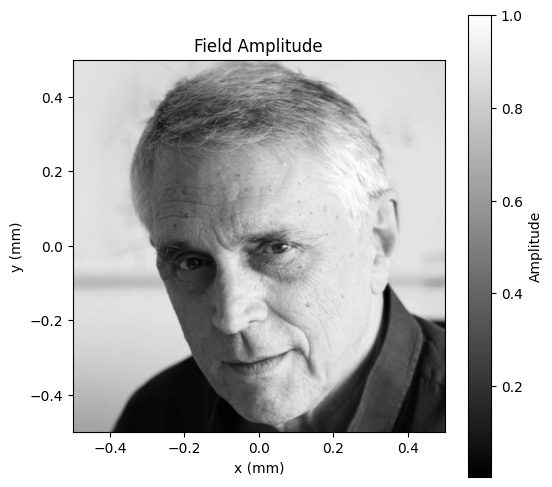

In [241]:
field = torch.tensor(np.load("field_1000.npy").reshape(1,1,1000,1000), device=device)

wvl = 633e-9
z = 1e-3

theta_x = 7 * np.pi / 180 
theta_y = 7 * np.pi / 180 
kx = (2 * np.pi / wvl) * np.sin(theta_x)
ky = (2 * np.pi / wvl) * np.sin(theta_y)

# use those functions for the Fourier transform
ft = lambda x: torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(x)))
ift = lambda x: torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(x)))

plt.figure(figsize=(6, 6))
plt.title("Field Amplitude")
plt.imshow(torch.abs(field[0, 0]).cpu().numpy(), cmap='gray', extent=[x[0]*1e3, x[-1]*1e3, y[0]*1e3, y[-1]*1e3])
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Amplitude")
plt.show()



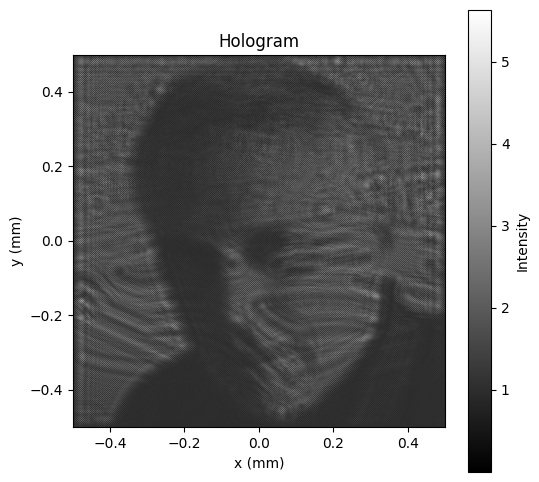

Number of max peaks: 1
Center peak position (Fourier space): tensor([500, 500])


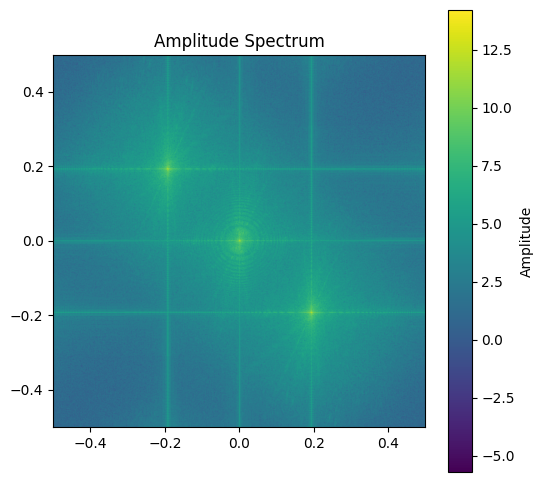

In [242]:
initial_size = 1000

prop_field = angular_spectrum_propagation(field, wvl, dx, z)

X, Y = X[None, None, :, :], Y[None, None, :, :]
plane_wave = torch.exp(1j * (kx * X + ky * Y))

hologram = torch.abs(prop_field + plane_wave) ** 2

plt.figure(figsize=(6, 6))
plt.title("Hologram")
plt.imshow(hologram[0, 0].cpu().numpy(), cmap='gray', extent=[y[0]*1e3, y[-1]*1e3, y[0]*1e3, y[-1]*1e3])
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Intensity")
plt.show()

holo_fft = ft(hologram)

# Find max peak position in Fourier space with a binary mask where the amplitude is equal to the max
# and the rest is zero

# Count number of locations equal to the max
amplitude_spectrum = torch.abs(holo_fft[0,0])
max_val = amplitude_spectrum.max()
num_max_peaks = torch.sum(amplitude_spectrum == max_val).item()
max_idx = torch.nonzero(amplitude_spectrum == amplitude_spectrum.max(), as_tuple=False)[0]

print(f"Number of max peaks: {num_max_peaks}")
print("Center peak position (Fourier space):", max_idx)


plt.figure(figsize=(6, 6))
plt.title("Amplitude Spectrum")
plt.imshow(np.log(amplitude_spectrum.cpu().numpy()), cmap='viridis', extent=[y[0]*1e3, y[-1]*1e3, y[0]*1e3, y[-1]*1e3])
plt.colorbar(label="Amplitude")
plt.show()



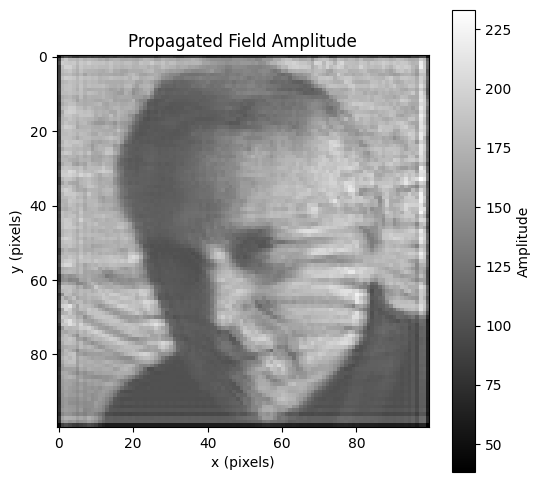

In [243]:
# indexes of the center peak
cx, cy = max_idx[0].item(), max_idx[1].item()
tile_size = 100
half_tile = tile_size // 2 

# Crop the center peak
cropped = holo_fft[0, 0, cx-half_tile:cx+half_tile, cy-half_tile:cy+half_tile].clone()
cropped = cropped[None, None]  # shape [1,1,100,100]


retrieved_tile = ift(cropped)
dx_new = (initial_size * dx) / tile_size

backprop = angular_spectrum_propagation(retrieved_tile, wvl, dx_new, -z)


plt.figure(figsize=(6, 6))
plt.title("Propagated Field Amplitude")
plt.imshow(torch.abs(backprop[0, 0]).cpu().numpy(), cmap='gray')
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.colorbar(label="Amplitude")
plt.show()


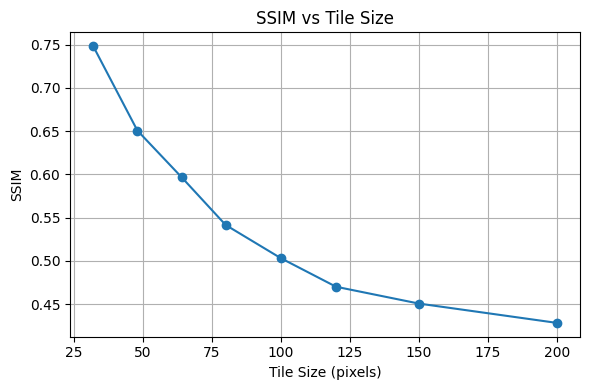

In [ ]:

tile_sizes = [32, 48, 64, 80, 100, 120, 150, 200]
ssim_scores = []

# Find peak in Fourier domain
amplitude_spectrum = torch.abs(holo_fft[0, 0])
max_idx = torch.nonzero(amplitude_spectrum == amplitude_spectrum.max(), as_tuple=False)[0]
cx, cy = max_idx[0].item(), max_idx[1].item()


# Loop over tile sizes
for T in tile_sizes:
    half_T = T // 2

    # Extract tile from Fourier domain
    cropped = holo_fft[0, 0, cx-half_T:cx+half_T, cy-half_T:cy+half_T].clone()
    cropped = cropped[None, None]  # shape [1, 1, T, T]

    # Inverse FFT to spatial domain
    retrieved = ift(cropped)

    # Update dx
    dx_new = (initial_size * dx) / T

    # Propagate field
    backpropagated = angular_spectrum_propagation(retrieved, wvl, dx_new, -z)
    recon_amp = torch.abs(backpropagated[0, 0])

    # Downsample reference field amplitude to match shape
    target_shape = recon_amp.shape
    downsampled = interpolate(
        torch.abs(field).reshape(1, 1, 1000, 1000),
        size=target_shape,
        mode="bilinear"
    ).reshape(*target_shape)

    # Compute SSIM
    recon_np = recon_amp.cpu().numpy()
    ref_np = downsampled.cpu().numpy()
    


    # Normalize both to [0, 1]
    recon_np = (recon_np - recon_np.min()) / (recon_np.max() - recon_np.min() + 1e-8)
    ref_np = (ref_np - ref_np.min()) / (ref_np.max() - ref_np.min() + 1e-8)
    score = ssim(recon_np, ref_np, data_range=ref_np.max() - ref_np.min())
    ssim_scores.append(score)

# Plot SSIM vs tile size
plt.figure(figsize=(6, 4))
plt.plot(tile_sizes, ssim_scores, marker='o')
plt.title("SSIM vs Tile Size")
plt.xlabel("Tile Size (pixels)")
plt.ylabel("SSIM") 
plt.grid(True)
plt.tight_layout()
plt.show()

The SSIM curve decreases monotonically as the tile size increases.
Smaller tiles tightly isolate the off-axis peak in the Fourier domain, resulting in coarse but structurally similar reconstructions when compared to the downsampled ground truth.
As the tile size increases, the reconstructed resolution improves but includes unwanted frequency components, leading to a lower SSIM despite potentially better visual detail.